<a href="https://colab.research.google.com/github/ykitaguchi77/AdvancedPytorch_Colab/blob/master/Pytorch%20Applstra_%E3%83%92%E3%83%88%E3%81%AE%E4%BA%88%E6%B8%AC%E3%81%A8%E6%AF%94%E8%BC%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#予測結果を1つずつ表示する

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#Google colabをマウント

In [2]:
'''
ファイル構成
My Drive---Deep learning---applstra------train----appl
                              |      |         |--stra
                              |      |    
                              |      |---val-------appl
                              |                 |--stra
                              |---applstra.pth
'''

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#モデルのロード

In [3]:
# モデルの設定
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device) #model_ftをGPUに載せる

# 重みロード
PATH = '/content/drive/My Drive/Deep_learning/applstra/applstra.pth'
model_ft.load_state_dict(torch.load(PATH))

#評価モードにする
model_ft.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 255MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
#モデルのサマリー（省略可）
from torchsummary import summary
summary(model_ft, (3, 224, 224))

#画像とラベル表示のための関数を定義

In [0]:
#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      label = os.path.basename(os.path.dirname(image_path))
      return(image_name, label)

'''
#変形後の画像を表示
def image_transform(image_path):

    image=Image.open(image_path)

    
    #変形した画像を表示する
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)])
    image_transformed = transform(image)
    plt.imshow(np.array(image_transformed))
'''

#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image_tensor = transform(image)

    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)

#モデルにした処理した画像を投入して予測結果を表示
def image_eval(image_tensor):
    output = model_ft(Variable(image_tensor))
    #print(output.size())  # torch.Size([1, 1000])
    #print(output)
    _, pred = torch.max(output, 1)
    predicted_label = class_name[pred]

    return(predicted_label)  #class_namで出力される

def showImage(image_path):
    #画像のインポート
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    #画像のリサイズ
    height = img.shape[0]
    width = img.shape[1]
    resized_img = cv2.resize(img, (int(width*300/height), 300))
    cv2_imshow(resized_img)

def calculateAccuracy (TP, TN, FP, FN):
    accuracy = (TP + TN)/ (TP + TN + FP + FN)
    precision  = TP/(FP + TP)
    recall = TP/(TP + FN)
    specificity = TN/(FP + TN)
    f_value = (2*recall*precision)/(recall+precision)

    print('Accuracy: ' + str(accuracy))
    print('Precision (positive predictive value): ' + str(precision))
    print('Recall (sensitivity): ' + str(recall))
    print('Specificity: ' + str(specificity))
    print('F_value: ' + str(f_value))
    
    return(accuracy, precision, recall, specificity, f_value)

def hum_prediction():
    while True:
        pred = input('ラベルを入力して下さい   '+ class_name[0]+'：「0」、'+class_name[1]+'：「1」')
        if pred == '0':
            hum_pred = class_name[0]
            break
        elif pred == '1':
            hum_pred = class_name[1]
            pred = 1
            break
        else:
            print('0か1を入力して下さい')
    return hum_pred  #class_nameで出力される

#メインプログラム



In [88]:
#ファイル名の取得
image_path = glob.glob("/content/drive/My Drive/Deep_learning/applstra/val/*/*")
random.shuffle(image_path)  #表示順をランダムにする
print(len(image_path))
print(image_path) 

#対象画像のパスからラベルを抜き出す


#ファイル名よりラベルを抜き出し、'class_name'と定義
class_name = []
class_path = glob.glob('/content/drive/My Drive/Deep_learning/applstra/val/*')
for i in class_path:
    class_name.append(os.path.basename(i))  
print(class_name)

127
['/content/drive/My Drive/Deep_learning/applstra/val/appl/ringo-tsugaru.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/top.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/web_food_photo1.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/top_img02.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/photo07.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/sp_main.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/sales_natsuakari.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/res_mon_ichigofair.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/title-yukiguni-ringo.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/ringo-1024x682.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/udoki_u_20190302_02.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/sd1_c8ab8625531af3bdb42243a9171e0cb567871f8b.jpg', '/content/drive/My Drive/Deep_learning/app

In [89]:
print(image_path)
#image_path = image_path[0:5]  #テスト用にデータセットを減らす

['/content/drive/My Drive/Deep_learning/applstra/val/appl/ringo-tsugaru.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/top.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/web_food_photo1.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/top_img02.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/photo07.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/sp_main.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/sales_natsuakari.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/res_mon_ichigofair.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/title-yukiguni-ringo.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/ringo-1024x682.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/stra/udoki_u_20190302_02.jpg', '/content/drive/My Drive/Deep_learning/applstra/val/appl/sd1_c8ab8625531af3bdb42243a9171e0cb567871f8b.jpg', '/content/drive/My Drive/Deep_learning/applstr

・True positive (TN) <br>
・False positive (FP) <br>
・True negative (TN) <br>
・False negative (FN) <br>

1. Accuracy = (TP + TN)/ (TP + TN + FP + FN)
2. Precision = TP/(FP + TP) ※positive predictive value
3. Recall = TP/(TP + FN)　※sensitivity
4. Specificity = TN/(FP + TN)
5. F_value = (2RecallPrecision)/(Recall+Precision)

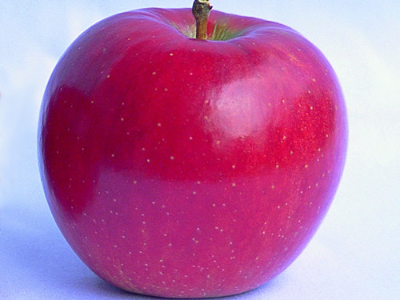

ラベルを入力して下さい   appl：「0」、stra：「1」0


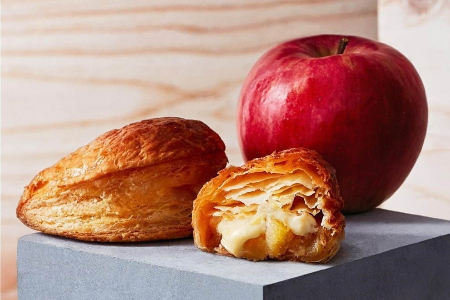

ラベルを入力して下さい   appl：「0」、stra：「1」0


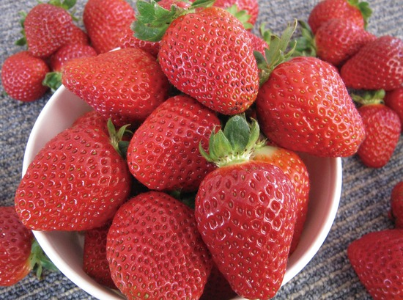

ラベルを入力して下さい   appl：「0」、stra：「1」1


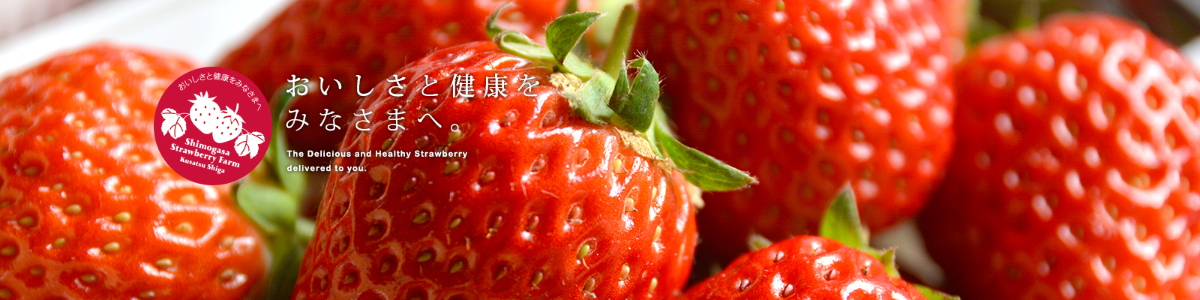

ラベルを入力して下さい   appl：「0」、stra：「1」1


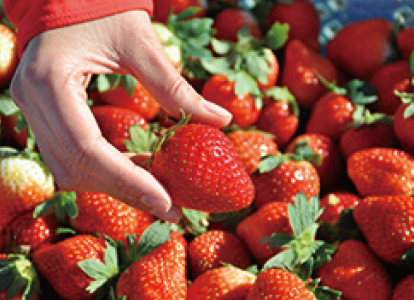

ラベルを入力して下さい   appl：「0」、stra：「1」1
Accuracy of model_pred:
Accuracy: 1.0
Precision (positive predictive value): 1.0
Recall (sensitivity): 1.0
Specificity: 1.0
F_value: 1.0

Accuracy of hum_pred:
Accuracy: 1.0
Precision (positive predictive value): 1.0
Recall (sensitivity): 1.0
Specificity: 1.0
F_value: 1.0


"\nprint('Accuracy: ' + str(accuracy))\nprint('Precision (positive predictive value): ' + str(precision))\nprint('Recall (sensitivity): ' + str(recall))\nprint('Specificity: ' + str(specificity))\nprint('F_value: ' + str(f_value))\n"

In [90]:
TP1, FP1, TN1, FN1, TP2, FP2, TN2, FN2 = [0,0,0,0,0,0,0,0]
image_name_list = []
label_list = []
model_pred_list = []
hum_pred_list = []
list = []

for i in image_path:
    image_name, label = getlabel(i)  #画像の名前とラベルを取得
    image_tensor = image_transform(i)  #予測のための画像下処理
    model_pred = image_eval(image_tensor)  #予測結果を出力   
    
    showImage(i) #画像を表示
    hum_pred = hum_prediction() #ヒトに判定してもらう

    image_name_list.append(image_name)
    label_list.append(label)
    model_pred_list.append(model_pred)
    hum_pred_list.append(hum_pred)

    #model_predのAccuracyを定義
    if label == class_name[0]:
        if model_pred == class_name[0]:
            TP1 += 1
        else:
            FN1 += 1
    elif label == class_name[1]:
        if model_pred == class_name[1]:
            TN1 += 1
        else:
            FP1 += 1

    #hum_predのAccuracyを定義
    if label == class_name[0]:
        if hum_pred == class_name[0]:
            TP2 += 1
        else:
            FN2 += 1
    elif label == class_name[1]:
        if hum_pred == class_name[1]:
            TN2 += 1
        else:
            FP2 += 1

#Accuracyを計算して表示
print('Accuracy of model_pred:')　
accuracy, precision, recall, specificity, f_value = calculateAccuracy (TP1, TN1, FP1, FN1)
print()
print('Accuracy of hum_pred:')
accuracy, precision, recall, specificity, f_value = calculateAccuracy (TP2, TN2, FP2, FN2)






    

In [87]:
print(image_name_list)
print(label_list)
print(model_pred_list)
print(hum_pred_list)

#ラベルのリストを表示
df = pd.DataFrame({'image_name':image_name_list, 'label':label_list, 'model_pred':model_pred_list, 'hum_pred':hum_pred_list})
print(df)

['strawberry-wallpaper.jpg', 'top-conD01.jpg', 'res_mon_ichigofair.jpg', 'top-22.jpg', 'tpc-thi-lifewithwood-013-main.jpg']
['stra', 'stra', 'stra', 'stra', 'appl']
['stra', 'stra', 'stra', 'appl', 'appl']
['appl', 'stra', 'stra', 'stra', 'appl']
                          image_name label model_pred hum_pred
0           strawberry-wallpaper.jpg  stra       stra     appl
1                     top-conD01.jpg  stra       stra     stra
2             res_mon_ichigofair.jpg  stra       stra     stra
3                         top-22.jpg  stra       appl     stra
4  tpc-thi-lifewithwood-013-main.jpg  appl       appl     appl


#1例ずつ各ラベルを表示する

Image: photo07.jpg
Label: stra
Model_pred: stra
hum_pred: stra


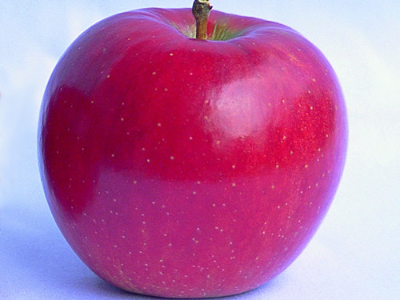


Image: photo07.jpg
Label: stra
Model_pred: stra
hum_pred: stra


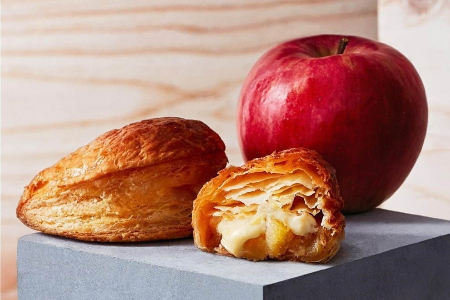


Image: photo07.jpg
Label: stra
Model_pred: stra
hum_pred: stra


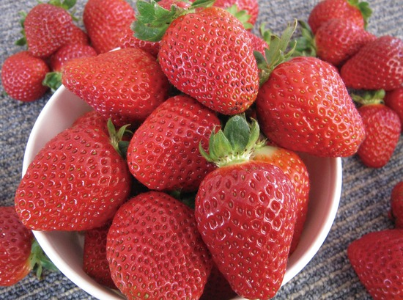


Image: photo07.jpg
Label: stra
Model_pred: stra
hum_pred: stra


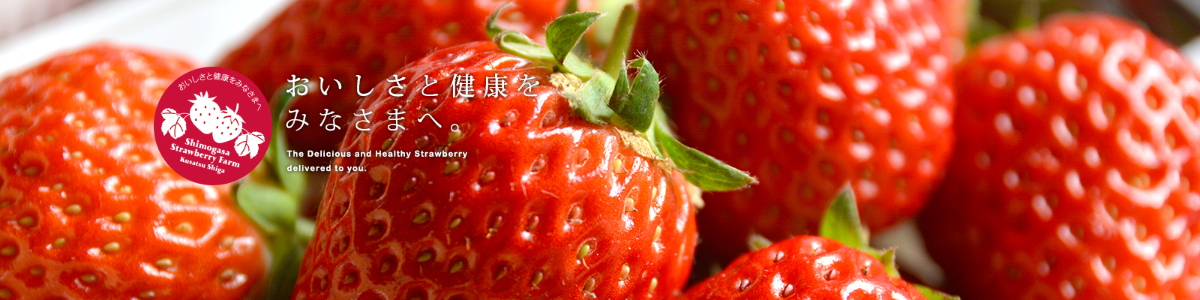


Image: photo07.jpg
Label: stra
Model_pred: stra
hum_pred: stra


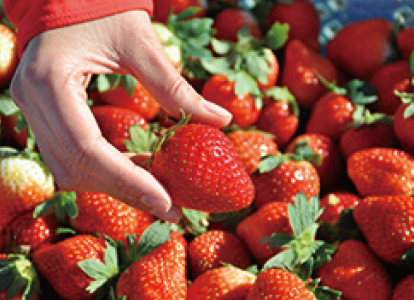

In [91]:
for i in image_path:
    print('Image: '+ image_name)
    print('Label: '+ label)
    print('Model_pred: '+ model_pred)
    print('hum_pred: '+ hum_pred)
    showImage(i)  #画像を表示
    print() #空白行を入れる
    time.sleep(0.1)
